In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("combined_matchups.csv")

# Drop rows with missing score or feature differences
df = df.dropna(subset=['SCORE_diff'])
feature_cols = [col for col in df.columns if col.endswith('_diff') and df[col].dtype != 'object']
df = df.dropna(subset=feature_cols)

# Define labels and normalized rewards
df['action'] = (df['SCORE_diff'] > 0).astype(int)
df['margin_reward'] = np.tanh(df['SCORE_diff'] / 10.0)  # Smooth, bounded between -1 and 1

# Extract features, targets, rewards
X = df[feature_cols]
y = df['action']
margins = df['margin_reward']


In [7]:
class QAgent(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(QAgent, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.model(x)


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
margins_train = margins.loc[X_train.index]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataLoader
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(margins_train.values),
    torch.LongTensor(y_train.values)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model, optimizer, loss
agent = QAgent(input_dim=X_train.shape[1])
optimizer = optim.Adam(agent.parameters(), lr=0.0001)
criterion = nn.SmoothL1Loss()
epsilon = 0.1  # Exploration rate

# Tracking
train_accuracies, test_accuracies, epoch_rewards = [], [], []

n_epochs = 100  # Feel free to increase now
patience = 10   # Stop if no improvement for 10 epochs
best_test_acc = 0
epochs_without_improvement = 0

for epoch in range(n_epochs):
    agent.train()
    total_reward, total_correct, total_samples = 0, 0, 0

    for X_batch, margin_batch, y_batch in train_loader:
        q_vals = agent(X_batch)

        # ε-greedy action
        random_actions = torch.randint(0, 2, y_batch.shape)
        max_actions = torch.argmax(q_vals, dim=1)
        take_random = torch.rand(y_batch.shape) < epsilon
        predictions = torch.where(take_random, random_actions, max_actions)

        # Margin-based reward
        reward = torch.where(predictions == y_batch, margin_batch, -margin_batch)
        total_reward += reward.sum().item()
        total_correct += (predictions == y_batch).sum().item()
        total_samples += len(y_batch)

        # Q-learning target
        target = q_vals.clone().detach()
        for i in range(len(y_batch)):
            target[i, y_batch[i]] = reward[i]

        loss = criterion(q_vals, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Metrics
    train_acc = total_correct / total_samples
    avg_reward = total_reward / total_samples
    train_accuracies.append(train_acc)
    epoch_rewards.append(avg_reward)

    # Test evaluation
    agent.eval()
    with torch.no_grad():
        test_preds = torch.argmax(agent(torch.FloatTensor(X_test_scaled)), dim=1).numpy()
        test_acc = (test_preds == y_test.values).mean()
        test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%} | Avg Reward: {avg_reward:.4f}")

    if test_acc >= best_test_acc:
        best_test_acc = test_acc
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"\n Early stopping at epoch {epoch+1} — no improvement in {patience} epochs.")
        break


Epoch  1 | Train Acc: 50.57% | Test Acc: 54.02% | Avg Reward: 0.4510
Epoch  2 | Train Acc: 53.45% | Test Acc: 56.32% | Avg Reward: 0.4334
Epoch  3 | Train Acc: 56.61% | Test Acc: 62.07% | Avg Reward: 0.4311
Epoch  4 | Train Acc: 56.32% | Test Acc: 65.52% | Avg Reward: 0.4224
Epoch  5 | Train Acc: 59.48% | Test Acc: 67.82% | Avg Reward: 0.5004
Epoch  6 | Train Acc: 62.64% | Test Acc: 71.26% | Avg Reward: 0.4899
Epoch  7 | Train Acc: 60.92% | Test Acc: 71.26% | Avg Reward: 0.5035
Epoch  8 | Train Acc: 60.63% | Test Acc: 71.26% | Avg Reward: 0.5522
Epoch  9 | Train Acc: 62.36% | Test Acc: 71.26% | Avg Reward: 0.5669
Epoch 10 | Train Acc: 61.49% | Test Acc: 72.41% | Avg Reward: 0.5288
Epoch 11 | Train Acc: 60.06% | Test Acc: 72.41% | Avg Reward: 0.5259
Epoch 12 | Train Acc: 63.51% | Test Acc: 72.41% | Avg Reward: 0.5394
Epoch 13 | Train Acc: 58.62% | Test Acc: 72.41% | Avg Reward: 0.5692
Epoch 14 | Train Acc: 63.51% | Test Acc: 72.41% | Avg Reward: 0.5261
Epoch 15 | Train Acc: 63.51% | Tes

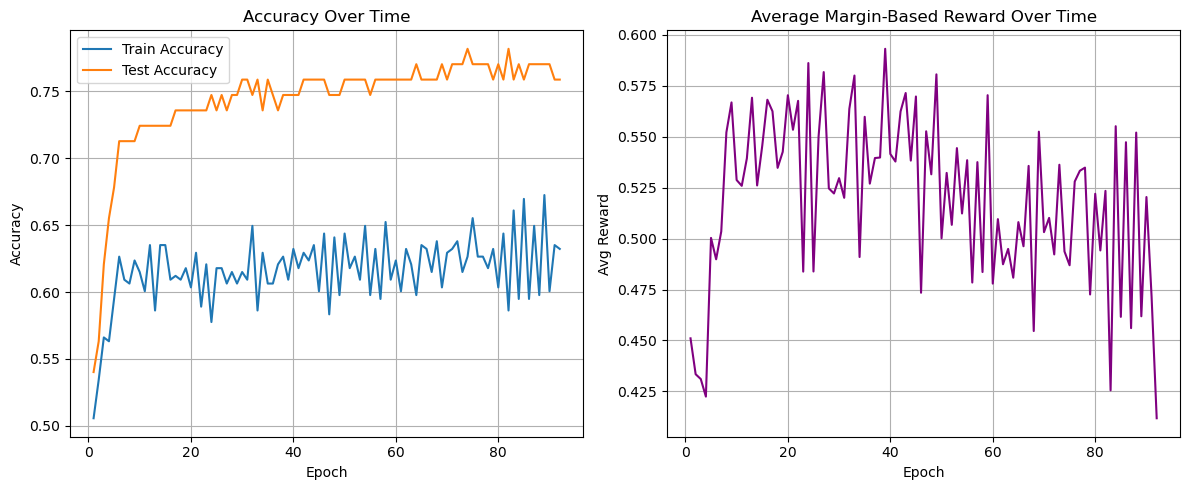

In [26]:
n_epochs = 92
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), epoch_rewards, color='purple')
plt.xlabel('Epoch')
plt.ylabel('Avg Reward')
plt.title('Average Margin-Based Reward Over Time')
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
import shap

# Prepare a background set for SHAP (random training samples)
background = torch.FloatTensor(X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)])

# Wrap SHAP explainer
shap_explainer = shap.Explainer(agent, background)


In [14]:
def simulate_bracket_with_shap(df_all, agent, scaler, feature_cols, shap_explainer, year=2024, show_waterfall=False):
    df_year = df_all[df_all['YEAR'] == year].copy()
    rounds = sorted(df_year['ROUND'].unique(), reverse=False)

    print(f"\n🏆 Simulating {year} Tournament Bracket with SHAP Explanations")

    for rnd in rounds:
        print(f"\n🔹 Round of {rnd}")
        matchups = df_year[df_year['ROUND'] == rnd]

        winners = []
        for i, row in matchups.iterrows():
            x = row[feature_cols].values.astype(np.float32).reshape(1, -1)
            x_scaled = scaler.transform(x)
            x_tensor = torch.FloatTensor(x_scaled)

            # Predict winner
            with torch.no_grad():
                q_vals = agent(x_tensor)
                pred = torch.argmax(q_vals).item()

            winner = row['Team_1'] if pred == 1 else row['Team_2']
            print(f"{row['Team_1']} vs {row['Team_2']} ➝ Predicted Winner: {winner}")

            # Compute SHAP values for this prediction
            shap_values = shap_explainer(x_tensor)

            # Display top contributing features
            contribs = pd.DataFrame({
                'feature': feature_cols,
                'shap_value': shap_values.values[0][pred]
            }).sort_values(by='shap_value', key=abs, ascending=False).head(5)

            print("  🔍 Top SHAP Contributors:")
            for _, row in contribs.iterrows():
                print(f"    {row['feature']}: {row['shap_value']:.4f}")

            # Optionally show waterfall plot
            if show_waterfall:
                shap.plots.waterfall(shap_values[0], max_display=10)

            winners.append(winner)

    print(f"\n🏆 Simulated Champion: {winners[-1]}")


In [15]:
simulate_bracket_with_shap(
    df_all=df,
    agent=agent,
    scaler=scaler,
    feature_cols=feature_cols,
    shap_explainer=shap_explainer,
    year=2024,
    show_waterfall=True  # Optional visual plot
)



🏆 Simulating 2024 Tournament Bracket with SHAP Explanations


UnboundLocalError: cannot access local variable 'winners' where it is not associated with a value